## Lotery Ticket Hypothesis:

Papers:
1. The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks
    Jonathan Frankle & Michael Carbin. ICLR 2019
    
    code: https://github.com/google-research/lottery-ticket-hypothesis
    
2. Deconstructing Lottery Tickets:Zeros, Signs, and the Supermask
     Hattie Zhou, Janice Lan, Rosanne Liu, and Jason Yosinski. NeurIPS 2019.


### A randomly-initialized, dense neural network contains a subnet- work that is initialized such that—when trained in isolation—it can match the test accuracy of the original network after training for at most the same number of iterations.

## What is Pruning?

Reduction in size of a network. 


* Which part of the network to remove? (filters/individual weight units/connections)  <img src="pruning.png" alt="Drawing" style="width: 300px;"/>

* What criteria to decide the removal?  (Gradients/Activation/Magnitued)

## Why Prunning?

* Storage

* Faster Inference (Sparse Ops support in hardware)

* Faster Training (in fine-tuning)

* Curiosity

## Pruning Procedure


1. Train a network

2. Prune it : remove filters/individual weight unites/connections/

3. Fine tune the pruned network.




__Difficult to train the pruned sparse network__

__Up to a certain level of pruning, a randomly reinitialized network can match the accuracy of the original network. Past this point, winning tickets continue to match the performance of the original network when randomly reinitialized networks cannot__

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from livelossplot import PlotLosses
import copy

In [2]:
from torchsummary import summary

In [3]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torch.optim.lr_scheduler import StepLR

from torchsummary import summary

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        
    train_loss /= len(test_loader.dataset)
    train_acc = 100. * correct / len(train_loader.dataset)
    return train_loss, train_acc

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    return test_loss, test_acc

def nnz(model):
    nonzero = total = 0
    for name, p in model.named_parameters():
        tensor = p.data.cpu().numpy()
        nz_count = np.count_nonzero(tensor)
        total_params = np.prod(tensor.shape)
        nonzero += nz_count
        total += total_params
    return (round((nonzero/total)*100,1))

In [6]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [8]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
model = Net()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [9]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [10]:
summary(model, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
         Dropout2d-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 128]       1,179,776
         Dropout2d-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 4.58
Estimated Total Size (MB): 5.10
----------------------------------------------------------------


## Save Original Init

In [11]:
initial_state_dict = copy.deepcopy(model.state_dict())

In [12]:
test_loss, test_acc = test(model, device, test_loader)
print(test_loss, test_acc)

2.299827972793579 11.0


## Initialize mask

In [13]:
step = 0
for name, param in model.named_parameters(): 
    if 'weight' in name:
        step = step + 1
mask = [None]* step 
step = 0
for name, param in model.named_parameters(): 
    if 'weight' in name:
        tensor = param.data.cpu().numpy()
        mask[step] = np.ones_like(tensor)
        step = step + 1

## Train

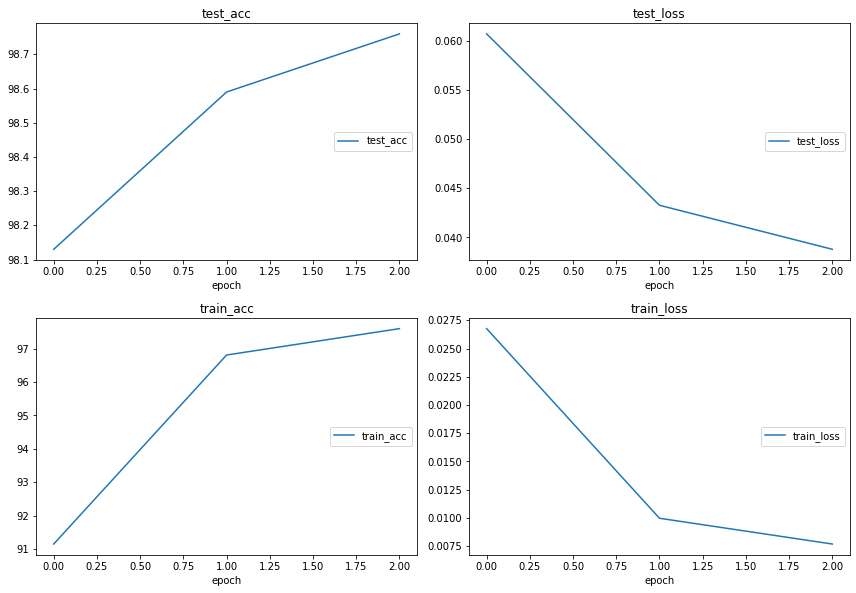

test_acc
	test_acc         	 (min:   98.130, max:   98.760, cur:   98.760)
test_loss
	test_loss        	 (min:    0.039, max:    0.061, cur:    0.039)
train_acc
	train_acc        	 (min:   91.153, max:   97.598, cur:   97.598)
train_loss
	train_loss       	 (min:    0.008, max:    0.027, cur:    0.008)


In [14]:
plotlosses = PlotLosses()
for epoch in range(1, 4):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(model, device, test_loader)
    #plotlosses.update({'train_loss' : train_loss, 'train_acc':train_acc, 'test_loss':test_loss, 'test_acc':test_acc})    
    #plotlosses.send()
    
print(f'train_loss:{train_loss:.4f}, test_loss:{test_loss:.4f}')
print(f'train_acc:{train_acc:.4f}, test_acc:{test_acc:.4f}')
#scheduler.step()

## Prune - Compute Mask

In [14]:
step = 0
percent = 20
for name, param in model.named_parameters():
    if 'weight' in name:
        tensor = param.data.cpu().numpy()
        alive = tensor[np.nonzero(tensor)] 
        percentile_value = np.percentile(abs(alive), percent)

        new_mask = np.where(abs(tensor) < percentile_value, 0, mask[step])

        param.data = torch.from_numpy(tensor * new_mask).to(device)
        mask[step] = new_mask
        step += 1

## Prune - Reset un-pruned to original init

In [34]:
step = 0
for name, param in model.named_parameters(): 
    if "weight" in name: 
        param.data = torch.from_numpy(mask[step] * initial_state_dict[name].cpu().numpy()).to(device)
        step = step + 1
    if "bias" in name:
        param.data = initial_state_dict[name]

In [35]:
test_loss, test_acc = test(model, device, test_loader)
print(test_loss, test_acc)

2.138620009994507 33.94


In [36]:
nnz(model)

38.4

## Re-Train

In [15]:
plotlosses = PlotLosses()
for epoch in range(1, 2):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(model, device, test_loader)
    
print(f'train_loss:{train_loss:.4f}, test_loss:{test_loss:.4f}')
print(f'train_acc:{train_acc:.4f}, test_acc:{test_acc:.4f}')

epoch:1, train_loss:0.006397327823168598, test_loss:0.031164943073224278
epoch:1, train_acc:97.94833333333334, test_acc:98.98


## Remove the masked weights

In [29]:
step = 0
for name, param in model.named_parameters(): 
    if "weight" in name: 
        param.data = torch.from_numpy(mask[step] * param.data.cpu().numpy()).to(device)
        step = step + 1

In [30]:
test_loss, test_acc = test(model, device, test_loader)
print(test_loss, test_acc)

0.18210604429244995 98.08


In [31]:
nnz(model)

48.0

## Prune again

In [32]:
step = 0
percent = 20
for name, param in model.named_parameters():
    if 'weight' in name:
        tensor = param.data.cpu().numpy()
        alive = tensor[np.nonzero(tensor)] 
        percentile_value = np.percentile(abs(alive), percent)

        new_mask = np.where(abs(tensor) < percentile_value, 0, mask[step])

        param.data = torch.from_numpy(tensor * new_mask).to(device)
        mask[step] = new_mask
        step += 1

In [33]:
nnz(model)

38.4